In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [65]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [48]:
path = './assets/face_mini'
filenames = glob.glob(path + '/**/*.jpg', recursive=True)
print(filenames[0])

./assets/face_mini\Aaron_Eckhart\Aaron_Eckhart_0001.jpg


# 5.1 Preprocessing

In [49]:
warehouse = []

In [50]:
for pth in filenames:
    img = image.load_img(pth, target_size=(100,100,3), interpolation="nearest")
    img = image.img_to_array(img)
    img = img/255.1
    warehouse.append(img)

In [51]:
warehouse = np.array(warehouse)
warehouse.shape

(3203, 100, 100, 3)

In [52]:
# (3203)
# 70 (2242): 30 (961) from test_size parameter
train_x,test_x = train_test_split(warehouse, random_state=32, test_size=0.3)
# (2242)
# 70 (1569): 30 (673)
train_x,val_x = train_test_split(train_x, random_state=32, test_size=0.3)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1569, 100, 100, 3)
(673, 100, 100, 3)
(961, 100, 100, 3)


# 5.2 Adding a Noise

In [53]:
noise_factor = [0.25, 0.75]

In [54]:
Ndist = 'normal'
Nmean = 0
Nstd  = 1

In [55]:
x_train_noisy = train_x + (noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape))
x_val_noisy   = val_x + (noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape))
x_test_noisy  = test_x + (noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


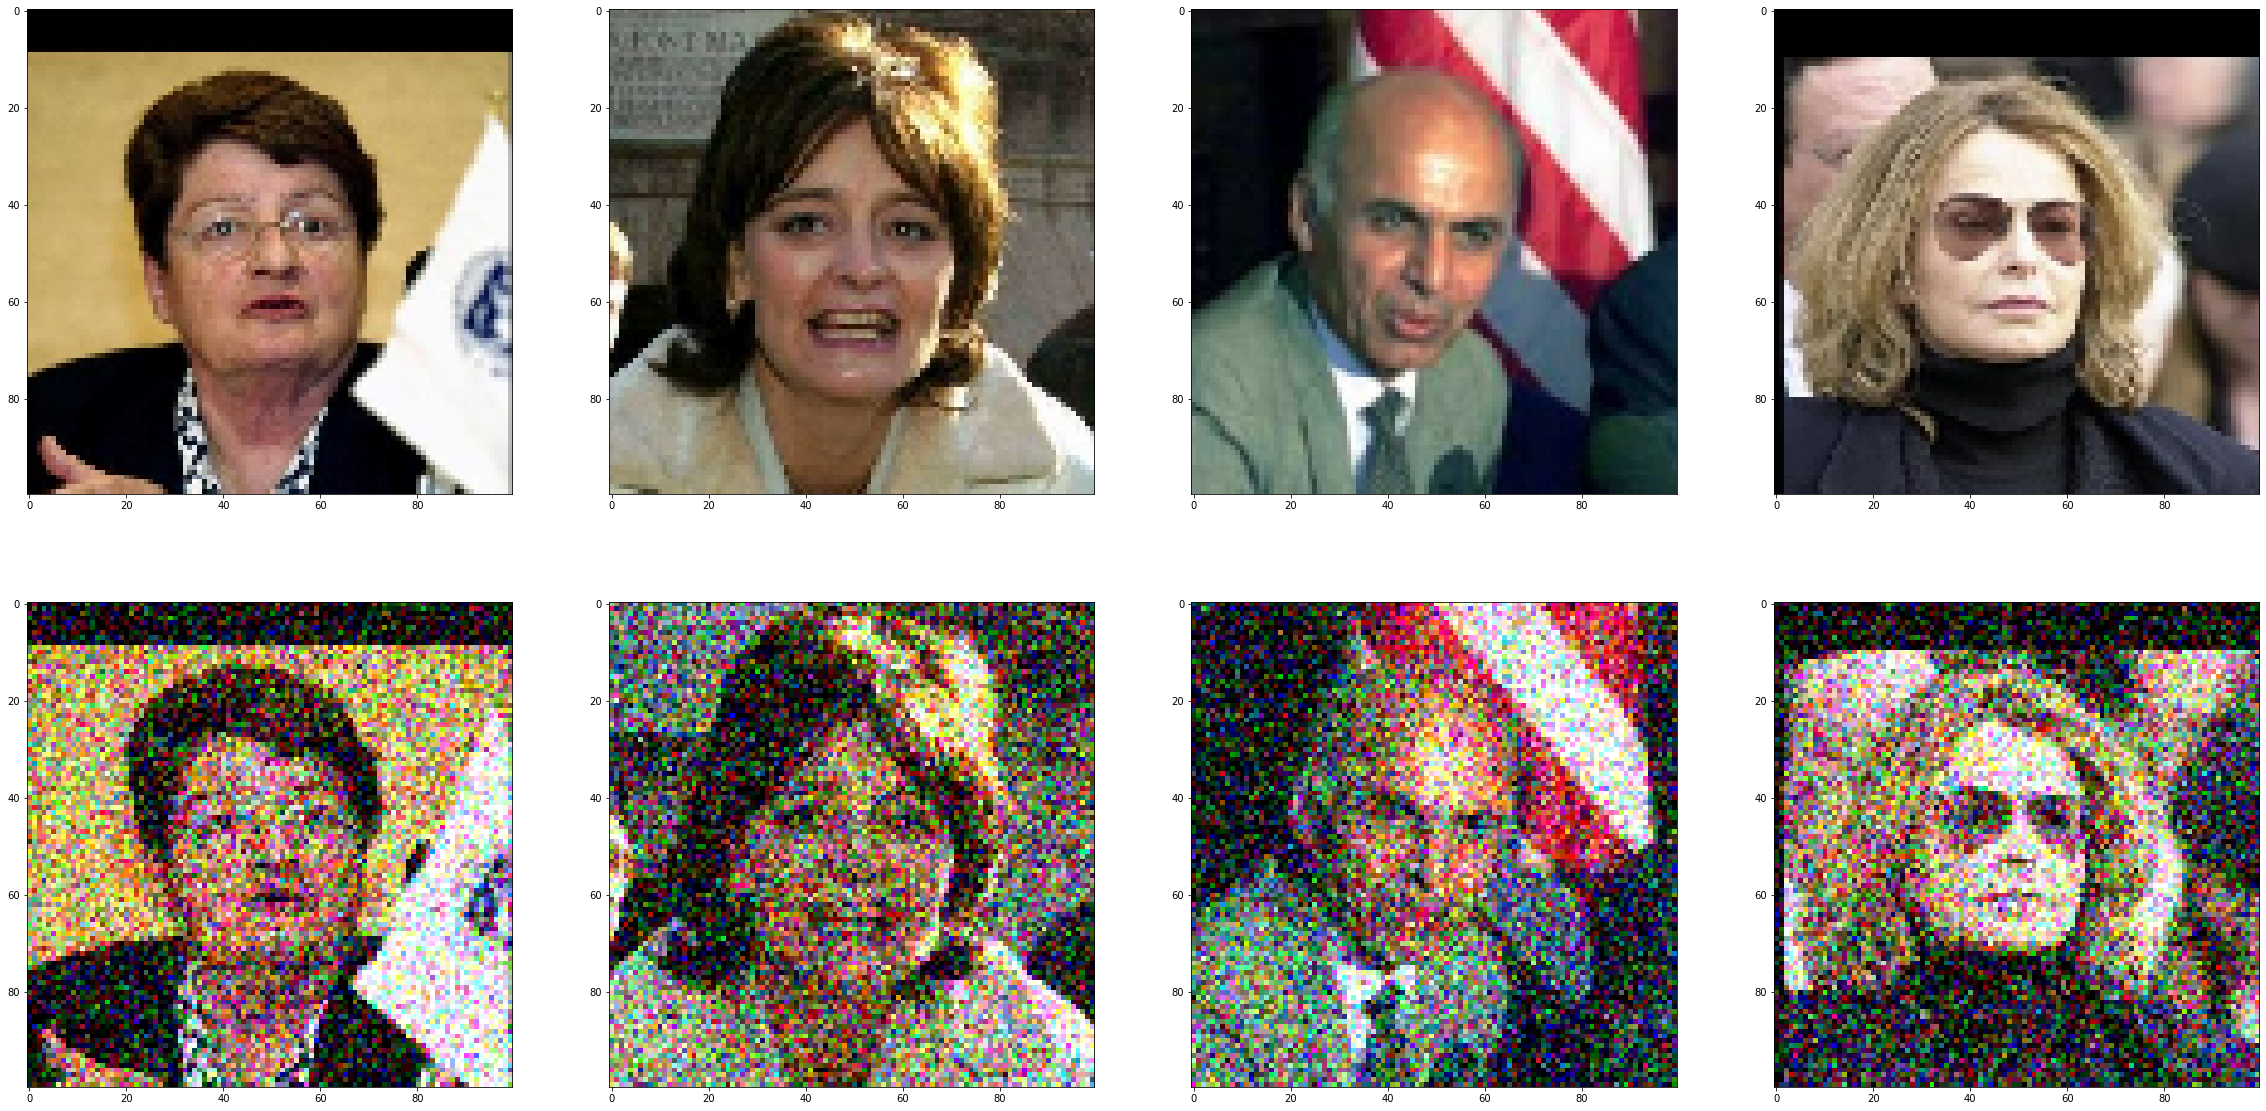

In [56]:
f, ax = plt.subplots(2,4, figsize=(40,20))
for i in range(4):
    img = train_x[i]
    ax[0,i].imshow(img)
for i in range(4):
    img_noisy = x_train_noisy[i]
    ax[1,i].imshow(img_noisy)
plt.show()

# 5.3 AutoEncoder

### Encoder

In [57]:
shap = img_noisy.shape
input_img = Input(shape=shap)
x1 = Conv2D(256,(3,3),activation='relu',padding='same')(input_img)
x2 = Conv2D(128,(3,3),activation='relu',padding='same')(x1)
x2 = MaxPool2D((2,2))(x2)
encoded = Conv2D(64,(3,3),activation='relu',padding='same')(x2)

### Decoder

In [58]:
x3 = Conv2D(64,(3,3),activation='relu',padding='same')(encoded)
x3 = UpSampling2D((2,2))(x3)
x2 = Conv2D(128,(3,3),activation='relu',padding='same')(x3)
x1 = Conv2D(256,(3,3),activation='relu',padding='same')(x2)
decoded = Conv2D(3,(3,3),padding='same')(x1)

### Optimizer

In [59]:
autoencoder = Model(input_img,decoded)
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 256)     7168      
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 64)        73792     
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 64)        36928     
                                                           

In [60]:
# if size equal to 100x100, it would working fine, but I need to find a way to enable GPU
epoch = 2 # 2,3,4
batch_size = 8 # 8,16,32
es = EarlyStopping(monitor='val_loss')
history = autoencoder.fit(x_train_noisy,
                          train_x,
                          epochs = epoch,
                          batch_size= batch_size,
                          shuffle=True,
                          validation_data=(x_val_noisy,val_x),
                          callbacks=es
                         )

Epoch 1/2
197/197 [==============================] - 384s 2s/step - loss: 0.0303 - val_loss: 0.0049
Epoch 2/2
197/197 [==============================] - 395s 2s/step - loss: 0.0043 - val_loss: 0.0044


In [61]:
predictions = autoencoder.predict(x_test_noisy)

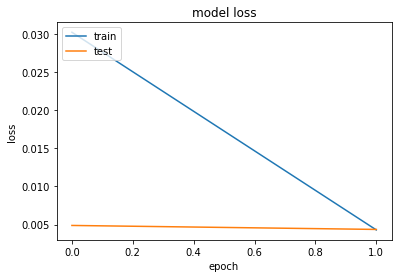

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


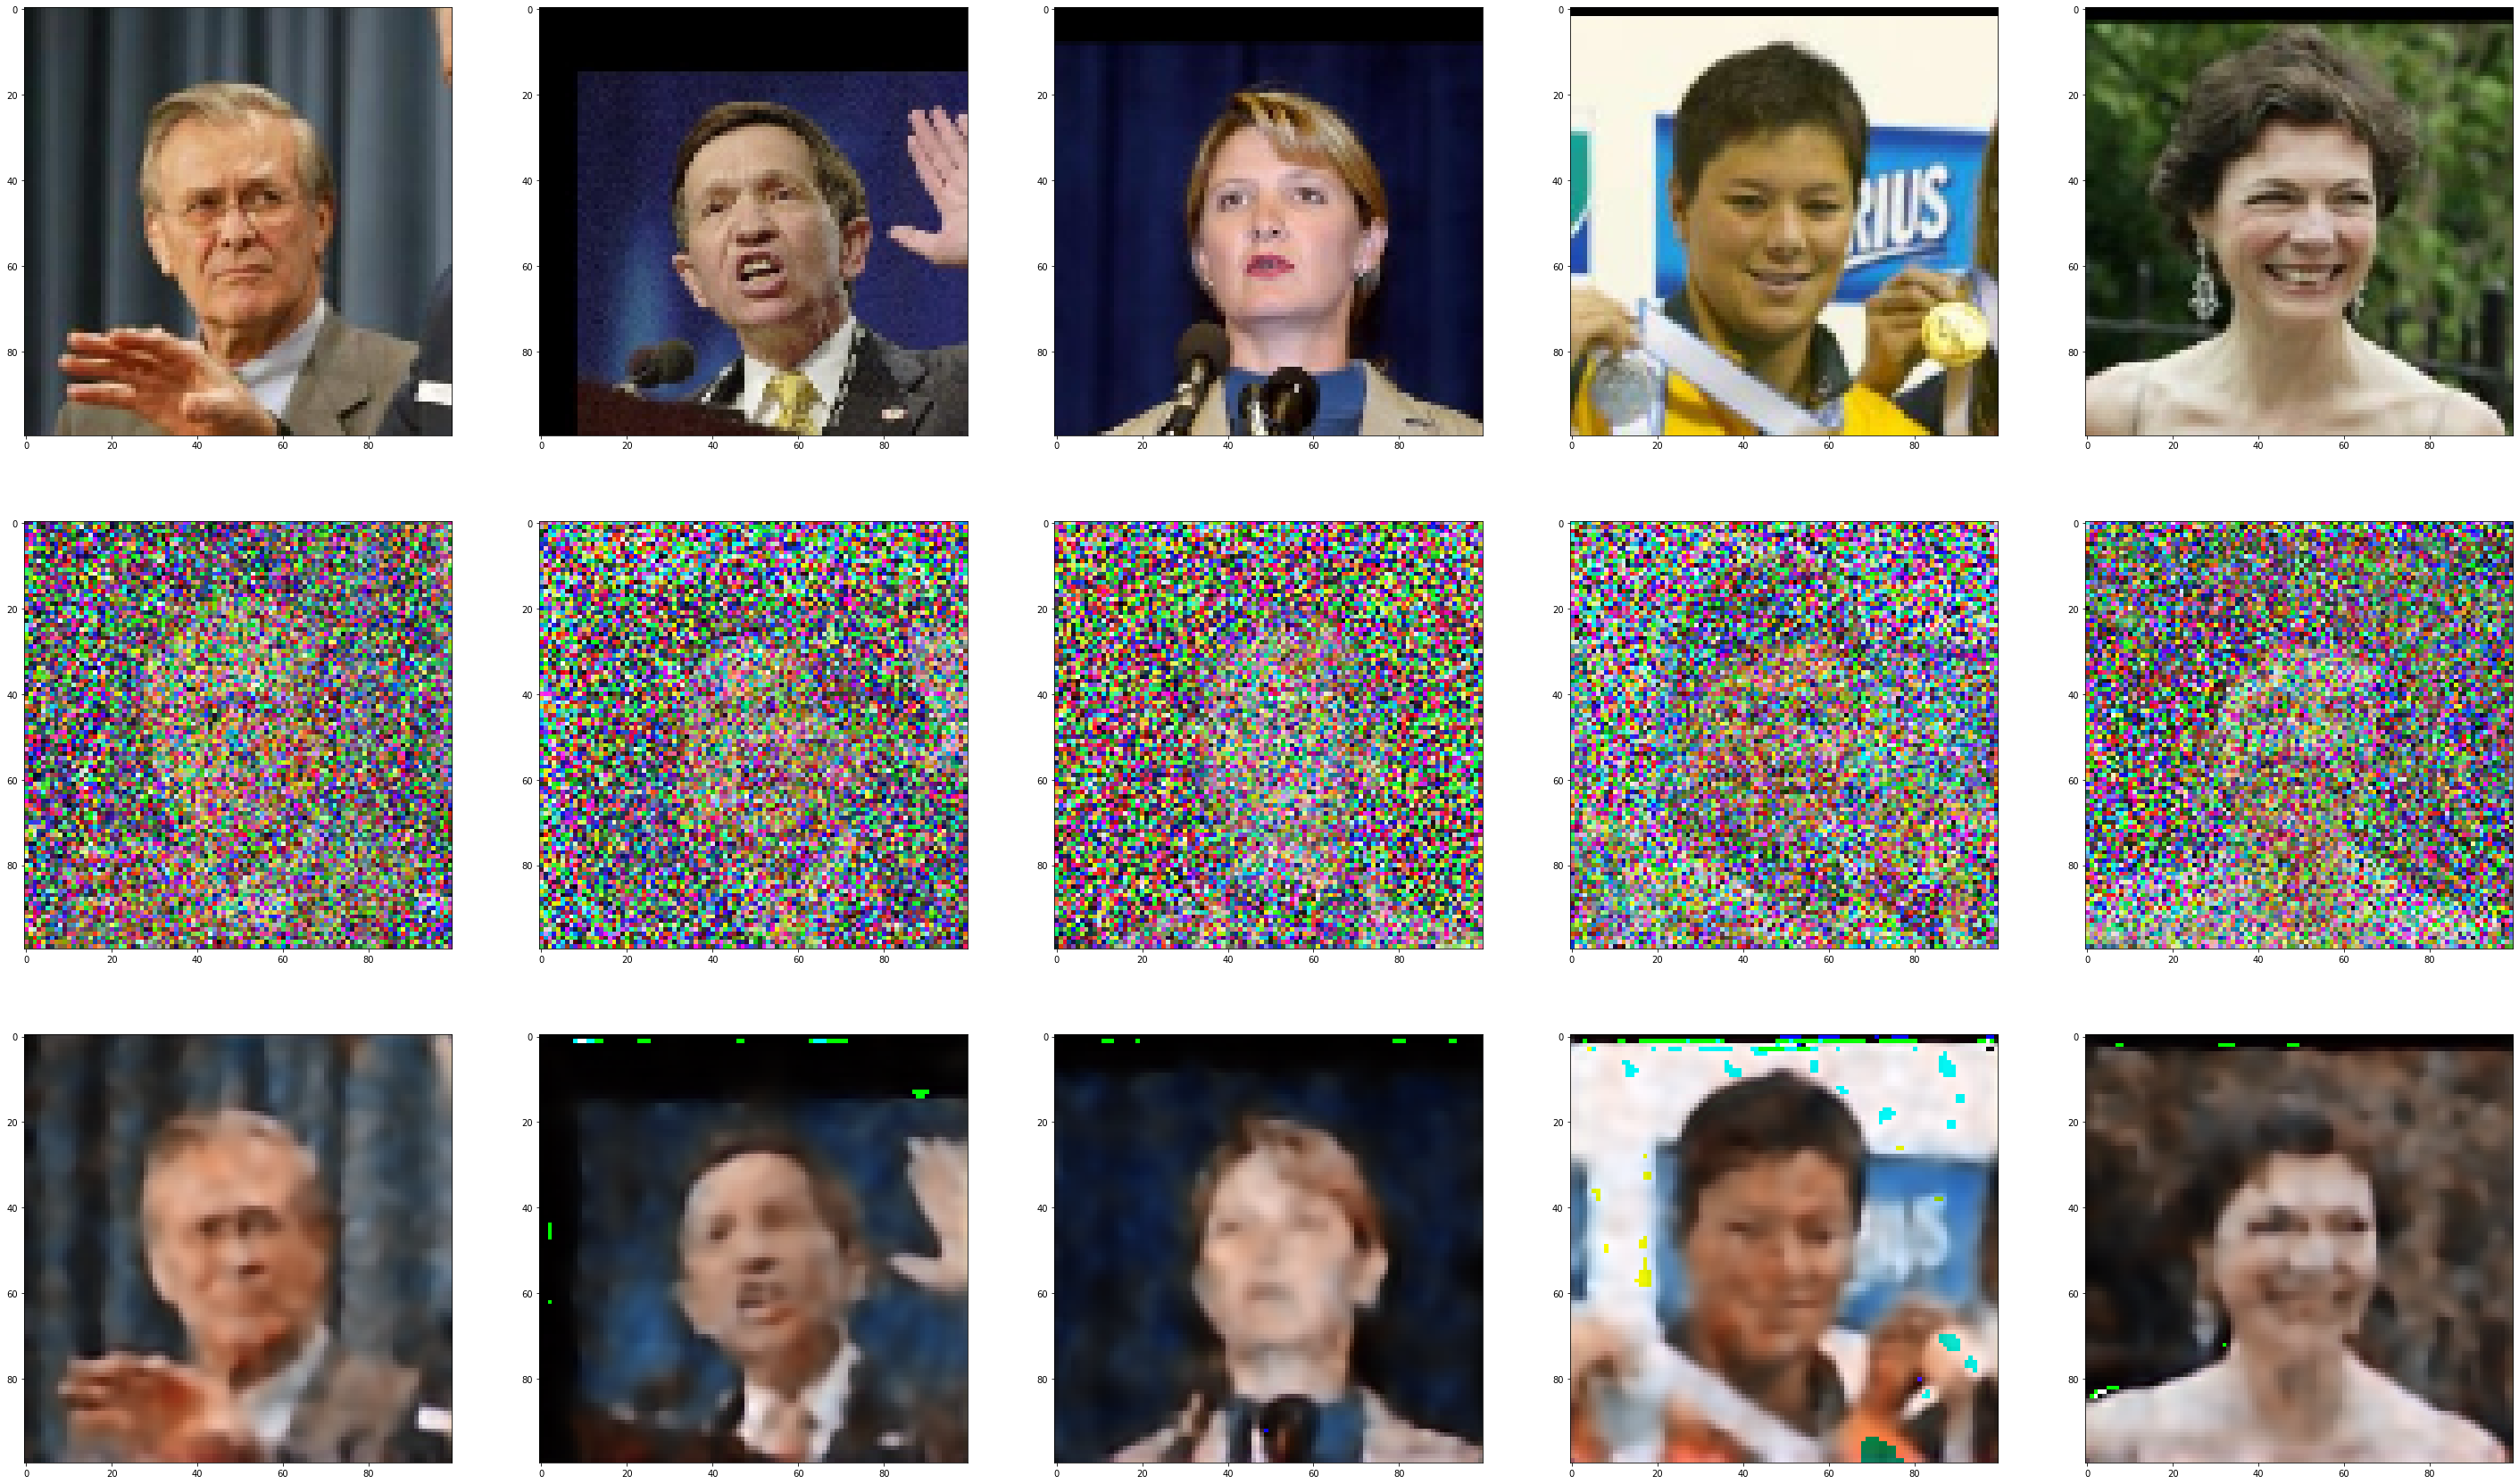

In [63]:
f,ax = plt.subplots(3,5,figsize=(50,30))
for i in range(5):
    img = test_x[i]
    ax[0,i].imshow(img)
for i in range(5):
    img = x_test_noisy[i]
    img = (img * 255).astype('uint8')
    ax[1,i].imshow(img)
for i in range(5):
    img = predictions[i]
    img = (img * 255).astype('uint8')
    ax[2,i].imshow(img)

plt.show()